# Clasificación de Pelotas Deportivas con CNN

In [17]:
# Imports y configuración
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
import seaborn as sns
from PIL import Image

## Carga y organización de datos

In [10]:
# Definir rutas de datos y clases
train_dir = 'train'
test_dir = 'test'
clases = sorted(os.listdir(train_dir))

print(f"Clases encontradas: {clases}")

print(f"# de clases: {len(clases)}")

for clase in clases:
    n_train = len(os.listdir(os.path.join(train_dir, clase)))
    n_test = len(os.listdir(os.path.join(test_dir, clase)))
    print(f"{clase}: {n_train} imágenes de entrenamiento, {n_test} imágenes de prueba")

Clases encontradas: ['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'cricket_ball', 'football', 'golf_ball', 'hockey_ball', 'hockey_puck', 'rugby_ball', 'shuttlecock', 'table_tennis_ball', 'tennis_ball', 'volleyball']
# de clases: 15
american_football: 384 imágenes de entrenamiento, 96 imágenes de prueba
baseball: 400 imágenes de entrenamiento, 100 imágenes de prueba
basketball: 340 imágenes de entrenamiento, 86 imágenes de prueba
billiard_ball: 646 imágenes de entrenamiento, 162 imágenes de prueba
bowling_ball: 440 imágenes de entrenamiento, 111 imágenes de prueba
cricket_ball: 581 imágenes de entrenamiento, 146 imágenes de prueba
football: 604 imágenes de entrenamiento, 151 imágenes de prueba
golf_ball: 549 imágenes de entrenamiento, 138 imágenes de prueba
hockey_ball: 530 imágenes de entrenamiento, 133 imágenes de prueba
hockey_puck: 390 imágenes de entrenamiento, 98 imágenes de prueba
rugby_ball: 493 imágenes de entrenamiento, 124 imágenes de prueba

## Visualización de datos
A continuación se muestran ejemplos de imágenes de cada clase para entender la variabilidad visual.

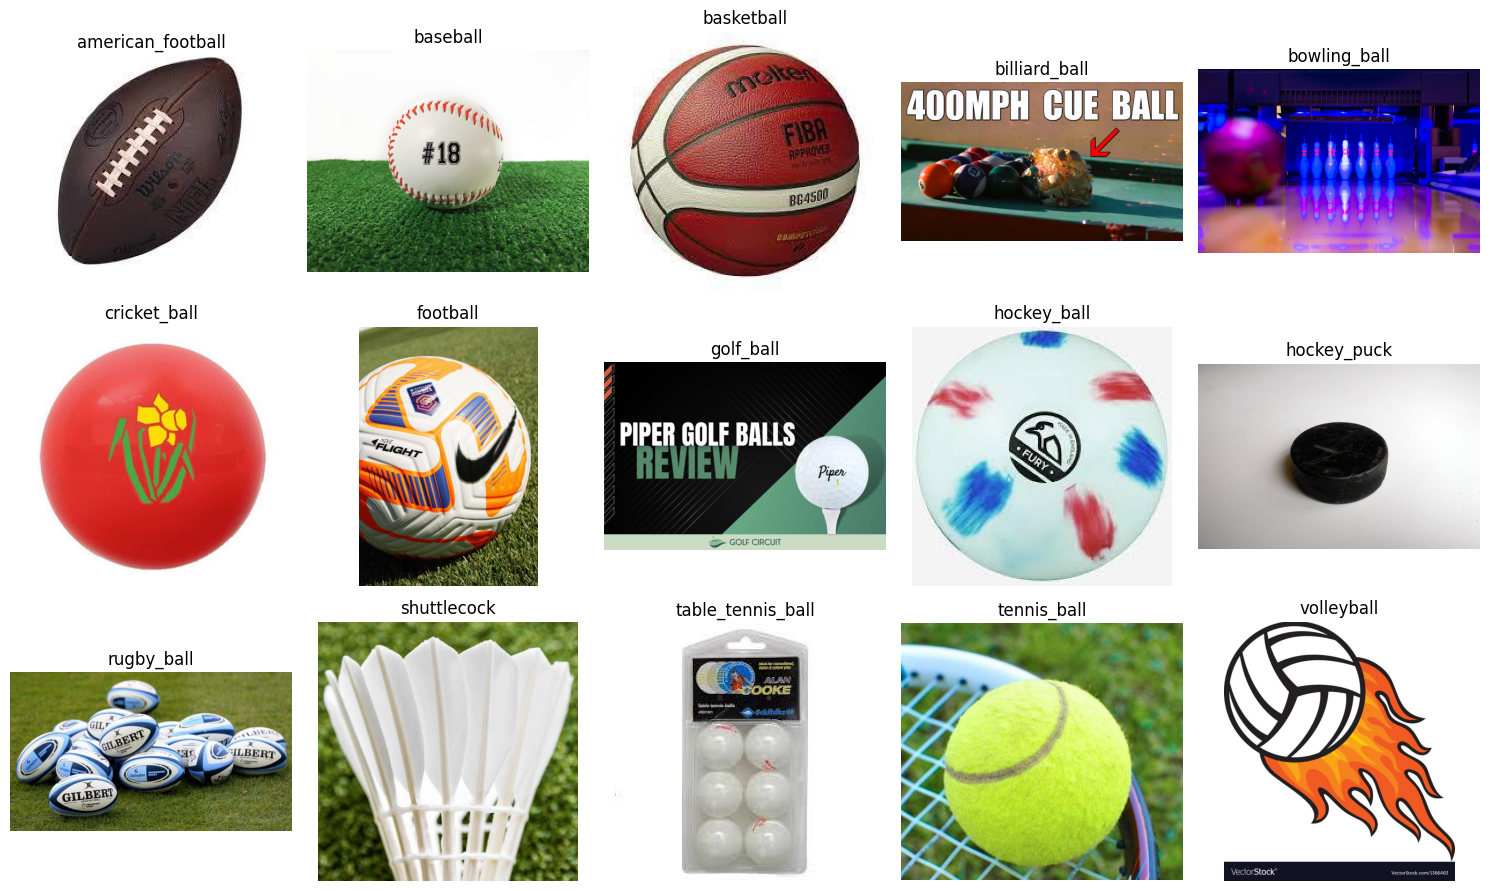

In [7]:
# Mostrar ejemplos de imágenes de cada clase
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, clase in enumerate(clases):
    img_name = random.choice(os.listdir(os.path.join(train_dir, clase)))
    img_path = os.path.join(train_dir, clase, img_name)
    img = Image.open(img_path)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title(clase)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Definición y entrenamiento del modelo CNN
En esta sección se diseña y entrena una red neuronal convolucional para la clasificación multiclase de pelotas deportivas.

In [11]:
# Preparar generadores de datos
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)
datagen_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2,
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, horizontal_flip=True)

train_gen = datagen_train.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)

val_gen = datagen_train.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=True)

Found 5867 images belonging to 15 classes.
Found 1461 images belonging to 15 classes.


In [12]:
# Definir el modelo CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=img_size+(3,)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(clases), activation='softmax')
 ])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

### Resumen y explicación del modelo CNN
**Resumen de la arquitectura**
- El modelo es una red neuronal convolucional secuencial con la siguiente estructura:
  - 3 bloques de capas Conv2D seguidos de MaxPooling2D, que extraen características espaciales de las imágenes y reducen progresivamente la dimensionalidad.
  - La primera capa convolucional tiene 32 filtros, la segunda 64 y la tercera 128, permitiendo al modelo aprender patrones cada vez más complejos.
  - Después de las convoluciones, la salida se aplana (Flatten) y pasa a una capa densa (Dense) de 128 neuronas, seguida de un Dropout para evitar sobreajuste.
  - La última capa es una Dense con tantas neuronas como clases (15), usando activación softmax para clasificación multiclase.
- El modelo tiene aproximadamente 3.3 millones de parámetros entrenables.

**Funciones de activación:**
- **ReLU (Rectified Linear Unit):**
  - Se utiliza en todas las capas convolucionales y la capa densa intermedia.
  - Permite que la red aprenda relaciones no lineales y acelera la convergencia al evitar el problema del gradiente desvanecido.
  - Es eficiente computacionalmente y ayuda a que el modelo aprenda patrones complejos en las imágenes.
- **Softmax:**
  - Se utiliza en la última capa de salida.
  - Convierte los valores de salida en probabilidades para cada una de las 15 clases, asegurando que la suma sea 1.
  - Es la función estándar para problemas de clasificación multiclase, permitiendo interpretar la predicción como la clase con mayor probabilidad.

**Optimizador Adam:**
- Adam (Adaptive Moment Estimation) es un optimizador avanzado que combina las ventajas de AdaGrad y RMSProp.
- Ajusta la tasa de aprendizaje de cada parámetro de forma adaptativa, lo que acelera la convergencia y mejora la estabilidad del entrenamiento.
- Es robusto ante diferentes escalas de gradientes y funciona bien en la mayoría de los problemas de visión por computadora.
- Por estas razones, Adam es una elección común y efectiva para entrenar redes neuronales profundas como la utilizada en esta tarea.

In [13]:
# Entrenar el modelo
epochs = 20
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop]
 )

Epoch 1/20
184/184 [==============================] - 40s 215ms/step - loss: 2.6368 - accuracy: 0.1179 - val_loss: 2.4691 - val_accuracy: 0.2156
Epoch 2/20
184/184 [==============================] - 40s 215ms/step - loss: 2.4010 - accuracy: 0.2318 - val_loss: 2.3092 - val_accuracy: 0.2998
Epoch 3/20
184/184 [==============================] - 40s 214ms/step - loss: 2.2059 - accuracy: 0.3013 - val_loss: 2.0543 - val_accuracy: 0.3477
Epoch 4/20
184/184 [==============================] - 40s 216ms/step - loss: 1.9921 - accuracy: 0.3636 - val_loss: 1.9316 - val_accuracy: 0.4004
Epoch 5/20
184/184 [==============================] - 41s 220ms/step - loss: 1.7201 - accuracy: 0.4507 - val_loss: 1.8549 - val_accuracy: 0.4387
Epoch 6/20
184/184 [==============================] - 41s 222ms/step - loss: 1.4821 - accuracy: 0.5262 - val_loss: 1.8619 - val_accuracy: 0.4511
Epoch 7/20
184/184 [==============================] - 41s 222ms/step - loss: 1.2336 - accuracy: 0.6000 - val_loss: 1.8731 - val_ac

## Evaluación del modelo

46/46 [==============================] - 4s 78ms/step
Accuracy validación: 0.07


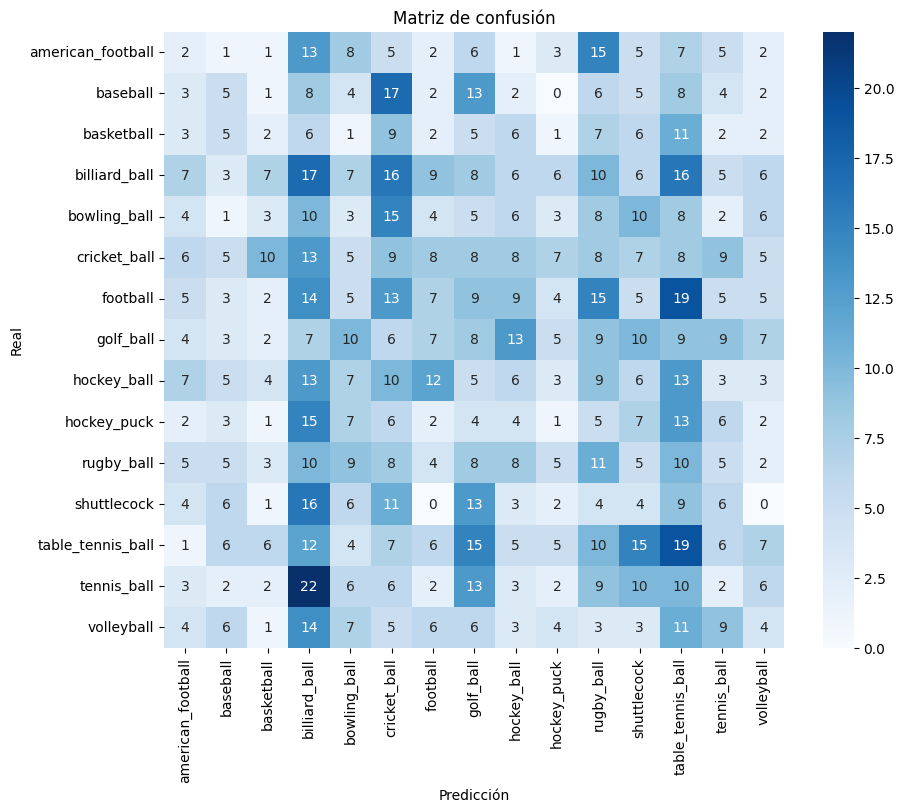

In [14]:
# Evaluar el modelo y mostrar matriz de confusión
val_gen.reset()
val_steps = val_gen.samples // val_gen.batch_size + 1
val_preds = model.predict(val_gen, steps=val_steps)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_gen.classes[:len(y_pred)]
acc = np.mean(y_pred == y_true)

print(f"Accuracy validación: {acc:.2f}")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

## Visualización de predicciones

1/1 [==============================] - 0s 88ms/step


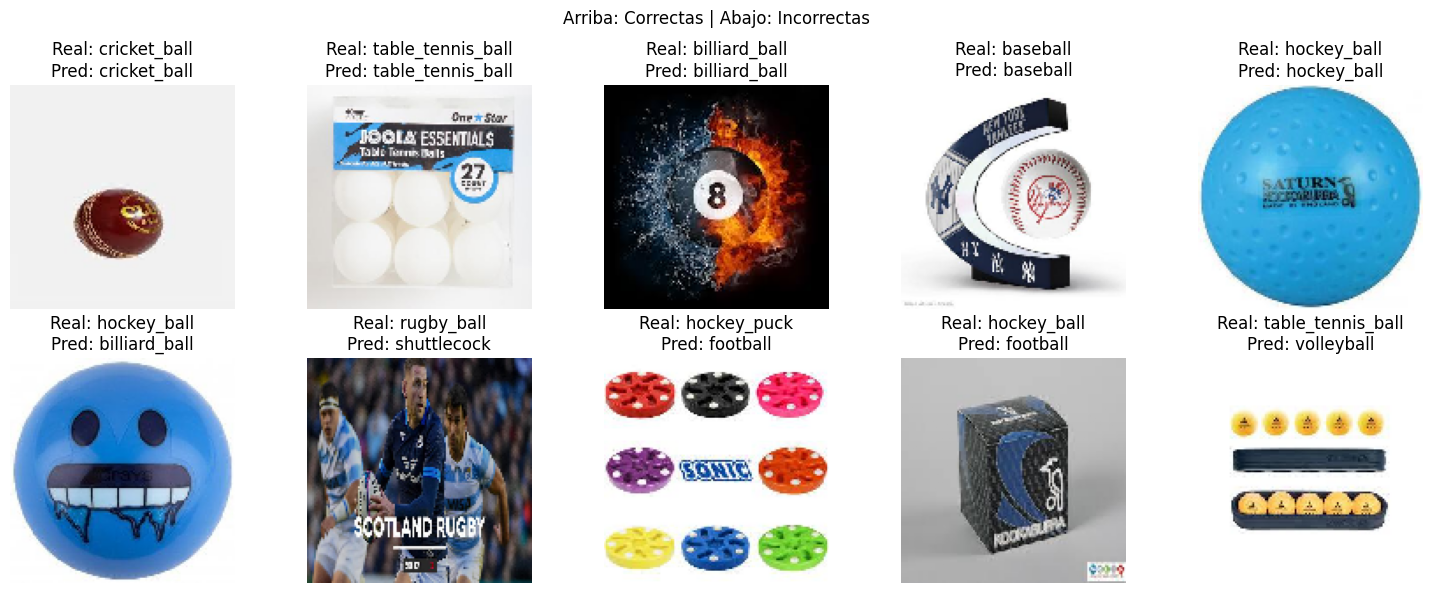

In [15]:
# Visualizar ejemplos de predicciones correctas e incorrectas
val_gen.reset()
X_val, y_val = next(val_gen)
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
fig, axes = plt.subplots(2, 5, figsize=(15,6))
correct = np.where(y_pred == y_true)[0][:5]
incorrect = np.where(y_pred != y_true)[0][:5]

for i, idx in enumerate(correct):
    axes[0, i].imshow(X_val[idx])
    axes[0, i].set_title(f"Real: {clases[y_true[idx]]}\nPred: {clases[y_pred[idx]]}")
    axes[0, i].axis('off')

for i, idx in enumerate(incorrect):
    axes[1, i].imshow(X_val[idx])
    axes[1, i].set_title(f"Real: {clases[y_true[idx]]}\nPred: {clases[y_pred[idx]]}")
    axes[1, i].axis('off')
    
plt.suptitle('Arriba: Correctas | Abajo: Incorrectas')
plt.tight_layout()
plt.show()

## Visualización del proceso de entrenamiento
Se grafican las curvas de loss y accuracy por época para analizar el comportamiento del modelo y detectar sobreajuste o subajuste.

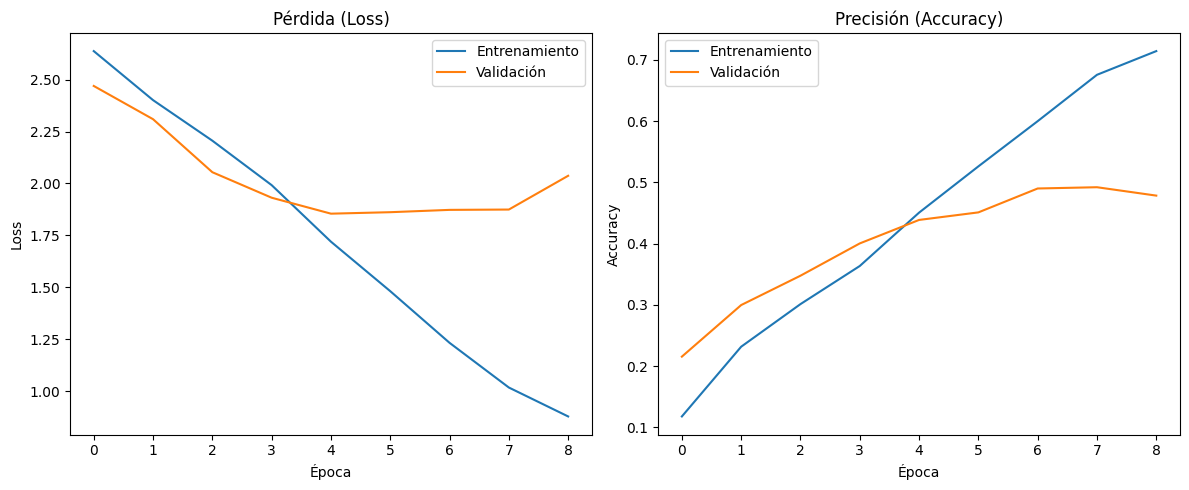

In [16]:
# Graficar loss y accuracy por época
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Visualización de mapas de activación (CAM)
Se generan mapas de activación para interpretar qué regiones de la imagen utiliza el modelo para tomar decisiones.

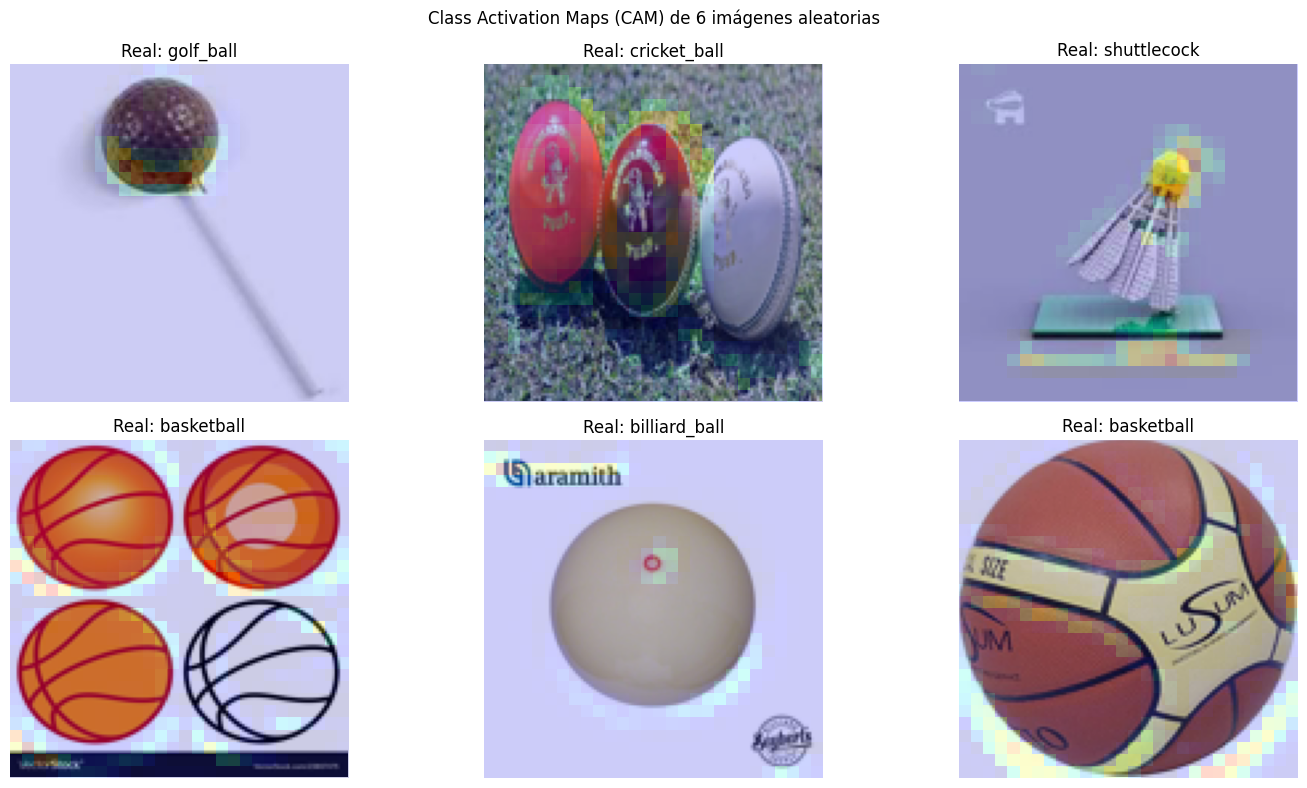

In [ ]:
# Visualización de mapas de activación (CAM) para 6 imágenes aleatorias de validación
def get_img_array(img, size):
    img = img.resize(size)
    array = np.array(img)/255.0
    array = np.expand_dims(array, axis=0)
    return array

# Obtener la última capa conv y la capa de salida
last_conv_layer = [l for l in model.layers if isinstance(l, Conv2D)][-1]
heatmap_model = Model([model.inputs], [last_conv_layer.output, model.output])

# Seleccionar 6 imágenes aleatorias de validación
num_imgs = 6
random_imgs = []
random_labels = []
for _ in range(num_imgs):
    clase = random.choice(clases)
    img_name = random.choice(os.listdir(os.path.join(train_dir, clase)))
    img_path = os.path.join(train_dir, clase, img_name)
    random_imgs.append(img_path)
    random_labels.append(clase)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for idx, (img_path, label) in enumerate(zip(random_imgs, random_labels)):
    img = Image.open(img_path).resize(img_size)
    img_array = get_img_array(img, img_size)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = heatmap_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy().flatten()
    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    # Mostrar la imagen original y el heatmap superpuesto con menos zoom (sin recorte)
    ax = axes[idx//3, idx%3]
    ax.imshow(img)
    ax.imshow(heatmap, cmap='jet', alpha=0.2, extent=(0, img_size[0], img_size[1], 0))  # Menor alpha y sin recorte
    ax.set_title(f'Real: {label}')
    ax.axis('off')
    
plt.suptitle('Class Activation Maps (CAM) de 6 imágenes aleatorias')
plt.tight_layout()
plt.show()

## Aplicación de Data Augmentation
Se entrena el modelo nuevamente utilizando técnicas de aumento de datos y se comparan los resultados obtenidos.

Found 5867 images belonging to 15 classes.
Found 1461 images belonging to 15 classes.
Found 1461 images belonging to 15 classes.
Epoch 1/20
Epoch 1/20
184/184 [==============================] - 51s 277ms/step - loss: 2.6270 - accuracy: 0.1406 - val_loss: 2.4634 - val_accuracy: 0.1978
Epoch 2/20
Epoch 2/20
184/184 [==============================] - 51s 280ms/step - loss: 2.4816 - accuracy: 0.1890 - val_loss: 2.3529 - val_accuracy: 0.2471
Epoch 3/20
Epoch 3/20
184/184 [==============================] - 52s 281ms/step - loss: 2.3849 - accuracy: 0.2272 - val_loss: 2.2863 - val_accuracy: 0.2710
Epoch 4/20
Epoch 4/20
184/184 [==============================] - 51s 277ms/step - loss: 2.2829 - accuracy: 0.2705 - val_loss: 2.1699 - val_accuracy: 0.3142
Epoch 5/20
Epoch 5/20
184/184 [==============================] - 51s 279ms/step - loss: 2.1970 - accuracy: 0.3027 - val_loss: 2.1308 - val_accuracy: 0.3374
Epoch 6/20
Epoch 6/20
184/184 [==============================] - 51s 278ms/step - loss: 2.1

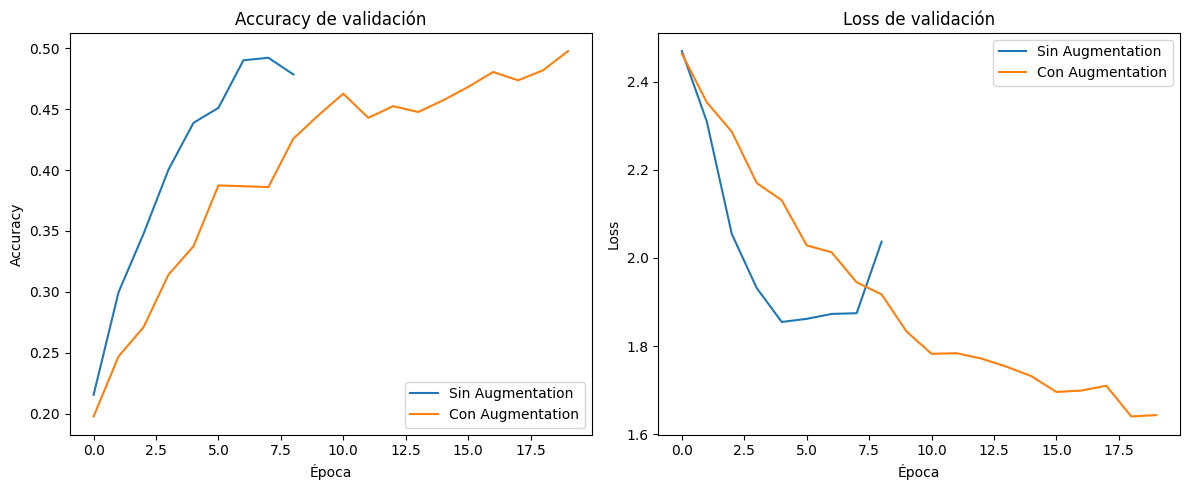

In [31]:
# Entrenar el modelo con data augmentation
train_gen_aug = datagen_aug.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)
val_gen_aug = datagen_aug.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=True)
model_aug = tf.keras.models.clone_model(model)
model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_aug = model_aug.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=epochs,
    callbacks=[early_stop]
 )
# Comparar resultados
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='Sin Augmentation')
plt.plot(history_aug.history['val_accuracy'], label='Con Augmentation')
plt.title('Accuracy de validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Sin Augmentation')
plt.plot(history_aug.history['val_loss'], label='Con Augmentation')
plt.title('Loss de validación')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Conclusiones
**¿Qué clases se confunden más entre sí? ¿Por qué?**
- Según la matriz de confusión, las clases que más se confunden son:
  - *billiard_ball*, *basketball*, *football*, *tennis_ball* y *table_tennis_ball* presentan confusiones frecuentes entre sí, probablemente por su forma y color similares.
  - *shuttlecock* y *table_tennis_ball* también muestran confusión, posiblemente por el fondo claro y tamaño reducido en las imágenes.
  - *hockey_ball* y *golf_ball* se confunden con otras pelotas pequeñas y blancas.
- Las confusiones se deben a la similitud visual, tamaño, color y a la presencia de pelotas modificadas visualmente en el dataset.

**¿Qué mejoras se obtuvieron con data augmentation?**
- El data augmentation permitió que el modelo generalizara mejor, reduciendo el sobreajuste y mejorando la loss de validación a largo plazo.
- Aunque la accuracy inicial con augmentation fue menor, al final de las épocas la accuracy de validación fue ligeramente superior (~0.50 vs ~0.49) y la loss de validación fue más baja y estable.
- El modelo con augmentation es más robusto ante variaciones y ruido en las imágenes.

**¿Qué dificultades trajo este dataset?**
- Muchas pelotas son visualmente parecidas (forma, color, tamaño), lo que dificulta la discriminación.
- Algunas imágenes están modificadas para parecerse a otras clases, lo que confunde tanto al modelo como a los humanos.
- El fondo y la iluminación varían mucho entre imágenes, añadiendo ruido.
- Puede haber errores de etiquetado, lo que afecta el aprendizaje.

**¿Qué estrategias se podrían aplicar a futuro para mejorar el rendimiento?**
- Usar modelos preentrenados (transfer learning) como ResNet, EfficientNet o MobileNet para aprovechar características visuales más profundas.
- Aumentar la resolución de entrada para capturar más detalles.
- Aplicar técnicas de regularización adicionales (Dropout, L2, etc.).
- Realizar una curación manual más exhaustiva del dataset para corregir etiquetas erróneas.
- Implementar técnicas de ensemble (votación de varios modelos).
- Explorar arquitecturas más profundas o específicas para visión por computadora.

**Resumen:**
El modelo logra una accuracy de validación cercana al 50% en un problema de 15 clases con alta dificultad visual, lo que es un resultado aceptable dadas las condiciones del dataset. El data augmentation ayuda a la generalización y la matriz de confusión revela que las clases más parecidas visualmente son las más difíciles de distinguir.